In [18]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

import matplotlib.cm as cm
from tqdm import tqdm

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from bayesian_statistics.utils_2 import *


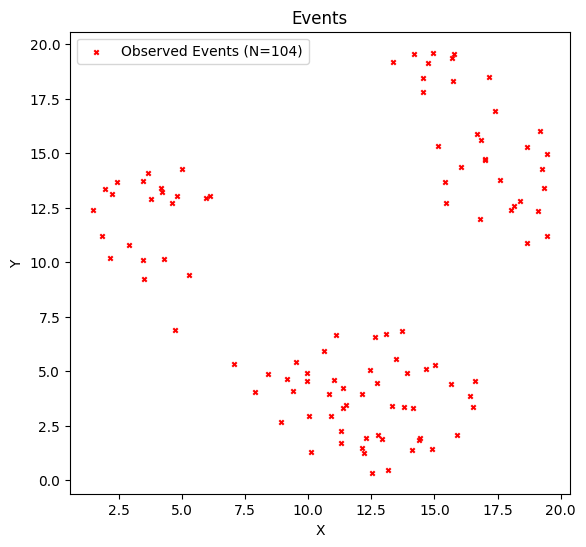

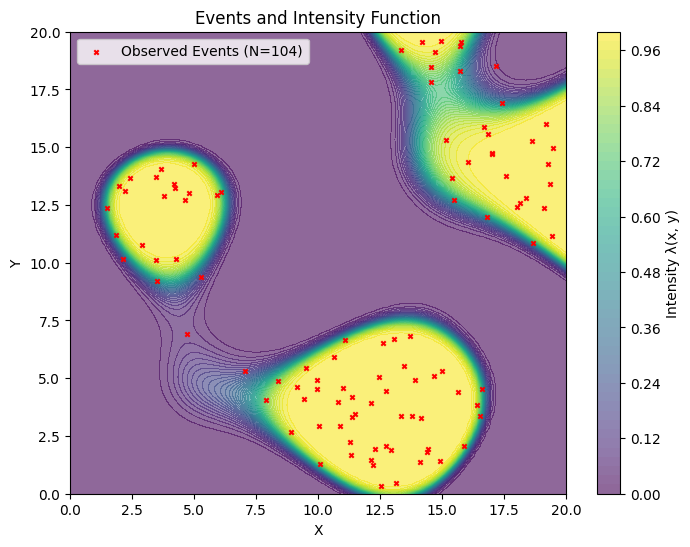

In [19]:
def create_complex_design_matrix(xy: np.ndarray, omega_x=np.pi / 5, omega_y=np.pi / 5, omega_xy=np.pi / 10) -> np.ndarray:
    """2次元の複雑な設計行列を生成する関数。xy の形状は (N, 2)"""
    x = xy[:, 0]
    y = xy[:, 1]
    return np.column_stack([
        np.ones_like(x),              # バイアス項
        x,                            # x の一次項
        y,                            # y の一次項
        x**2,                         # x の二次項
        y**2,                         # y の二次項
        x * y,                        # 相互作用項
        np.sin(omega_x * x),          # x に関する正弦関数
        np.cos(omega_x * x),          # x に関する余弦関数
        np.sin(omega_y * y),          # y に関する正弦関数
        np.cos(omega_y * y),          # y に関する余弦関数
        np.sin(omega_xy * (x + y)),   # x + y に関する正弦関数
        np.cos(omega_xy * (x - y))    # x - y に関する余弦関数
    ])

# 真のパラメータ
beta_true = np.array([
    -1.0,    # バイアス項
    -0.1,     # x の一次項
    -0.5,    # y の一次項
    -0.05,     # x^2 の項
    -0.1,    # y^2 の項
    0.2,     # x * y の項
    4.0,     # sin(ωx x) の項
    -4.0,    # cos(ωx x) の項
    4.0,     # sin(ωy y) の項
    -4.0,    # cos(ωy y) の項
    -9.0,     # sin(ωxy (x + y)) の項
    -7.0     # cos(ωxy (x - y)) の項
])
lambda_star_true = 1.0  # 真の λ*


# 領域の設定
region = [(0, 20), (0, 20)]  # x と y の範囲

# 真の強度関数の設定
true_intensity_func = IntensityFunction(
    design_matrix_func=create_complex_design_matrix,
    beta=beta_true,
    lambda_star=lambda_star_true
)

# データの生成
W_obs, y_obs, X_obs = generate_IPP(region, true_intensity_func, generate_U_flag=False)

# イベントのプロット
plot_events_2d(region, X_obs[y_obs == 1], true_intensity_func, plot_intensity=False)
plot_events_2d(region, X_obs[y_obs == 1], true_intensity_func, plot_intensity=True)


In [13]:
# 事前分布の設定
prior_beta_mean = np.zeros(len(beta_true))
prior_beta_cov = np.eye(len(beta_true)) * 10
prior_lambda_shape = 2.0
prior_lambda_rate = 1.0

# MCMC の実行
num_iterations = 10000
beta_samples, lambda_star_samples = mcmc_sampler(
    region=region,
    intensity_func=true_intensity_func.copy(),  # コピーを渡す
    y_obs=y_obs,
    X_obs=X_obs,
    num_iterations=num_iterations,
    prior_beta_mean=prior_beta_mean,
    prior_beta_cov=prior_beta_cov,
    prior_lambda_shape=prior_lambda_shape,
    prior_lambda_rate=prior_lambda_rate
)

burn_in = 500  
beta_samples = np.array(beta_samples)[burn_in:, :]
lambda_star_samples = np.array(lambda_star_samples)[burn_in:]


100%|██████████| 10000/10000 [00:17<00:00, 577.22it/s]


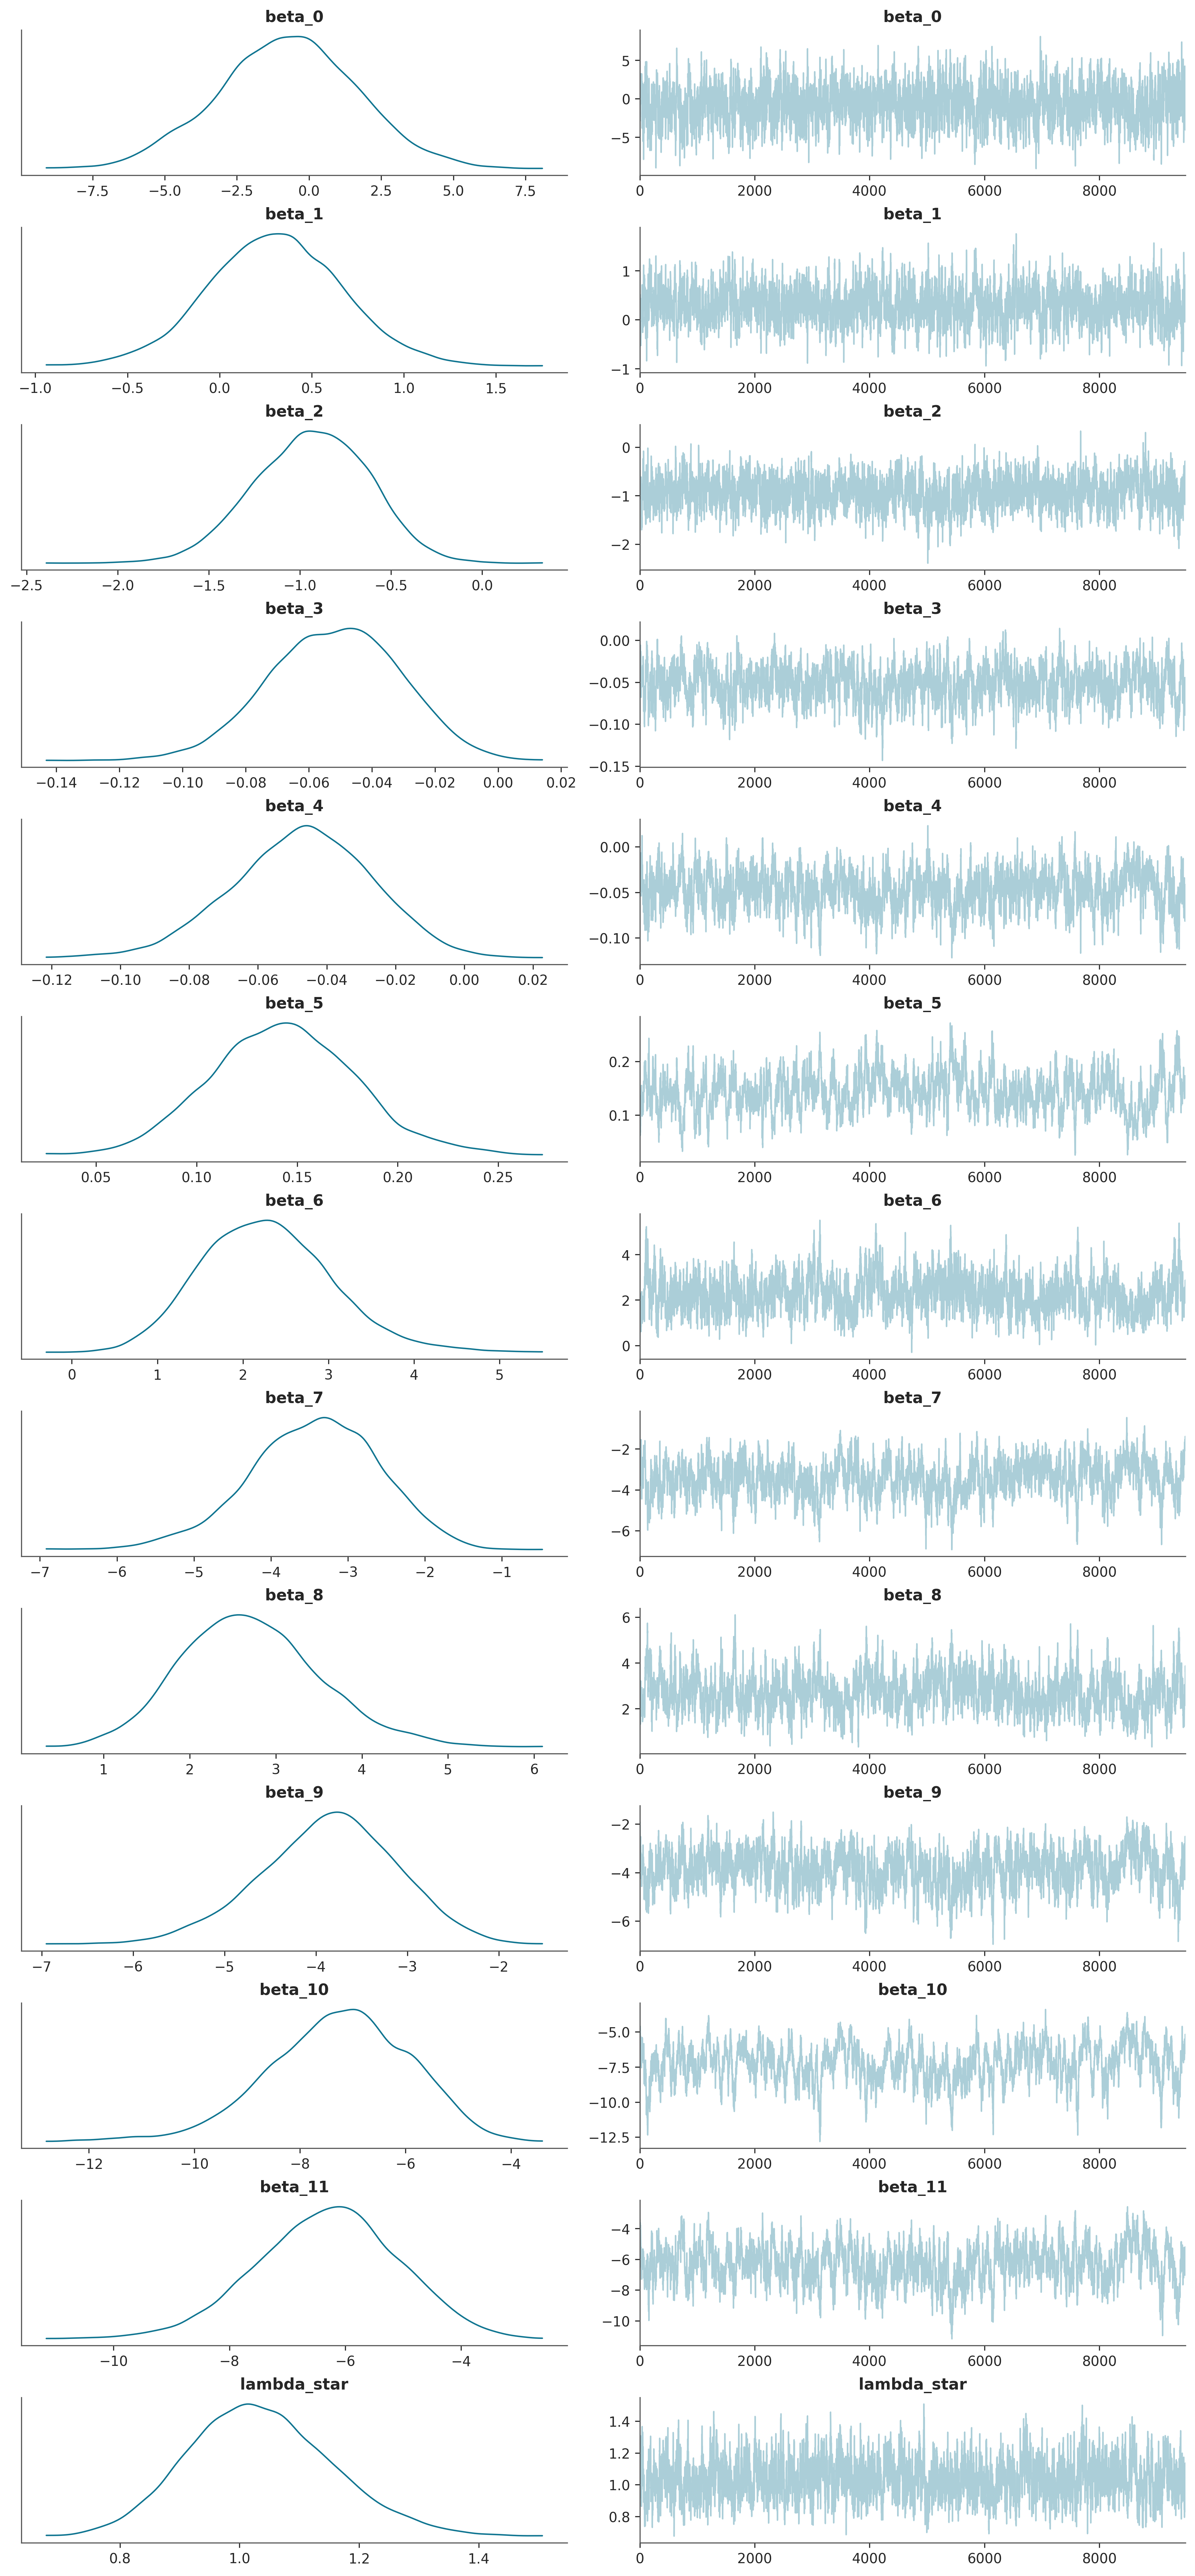

arviz - WARNING - Shape validation failed: input_shape: (1, 9500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_0      -0.757  2.417  -5.253    3.888      0.085    0.060     807.0   
beta_1       0.303  0.363  -0.384    0.990      0.013    0.009     760.0   
beta_2      -0.937  0.315  -1.535   -0.376      0.013    0.009     570.0   
beta_3      -0.052  0.021  -0.091   -0.014      0.001    0.001     372.0   
beta_4      -0.047  0.020  -0.087   -0.011      0.001    0.001     278.0   
beta_5       0.143  0.036   0.074    0.210      0.003    0.002     195.0   
beta_6       2.274  0.766   0.910    3.747      0.052    0.037     224.0   
beta_7      -3.440  0.846  -5.011   -1.844      0.058    0.041     211.0   
beta_8       2.712  0.807   1.260    4.299      0.051    0.036     244.0   
beta_9      -3.865  0.750  -5.313   -2.484      0.054    0.038     192.0   
beta_10     -7.268  1.342  -9.758   -4.858      0.107    0.076     147.0   
beta_11     -6.306  1.225  -8.681   -4.113      0.085    0.060     211.0   
lambda_star  1.036  0.120   0.815    1.265      0.005    0.004     525.0   

             ess_tail  r_hat  
beta_0         1798.0    NaN  
beta_1         1455.0    NaN  
beta_2         1245.0    NaN  
beta_3         1057.0    NaN  
beta_4          720.0    NaN  
beta_5          368.0    NaN  
beta_6          683.0    NaN  
beta_7          484.0    NaN  
beta_8          690.0    NaN  
beta_9          479.0    NaN  
beta_10         377.0    NaN  
beta_11         398.0    NaN  
lambda_star    1523.0    NaN

In [15]:
import arviz as az

# サンプル数とパラメータ数の取得
num_samples, num_beta = beta_samples.shape

# パラメータ名とサンプルの辞書を作成
posterior_samples = {}

# βの各成分を辞書に追加
for i in range(num_beta):
    param_name = f'beta_{i}'
    posterior_samples[param_name] = beta_samples[:, i]

# λ*を辞書に追加
posterior_samples['lambda_star'] = lambda_star_samples

# InferenceDataオブジェクトを作成
idata = az.from_dict(posterior=posterior_samples)

# --- ArviZによる可視化と解析 ---
az.style.use("arviz-doc")


# トレースプロット
az.plot_trace(idata)
plt.show()

# 事後分布のプロット
az.plot_posterior(idata)
plt.show()

# 自己相関プロット
az.plot_autocorr(idata)
plt.show()

# 統計的な概要情報の表示
summary_df = az.summary(idata)
display(summary_df)

# スタイルをリセット
az.style.use("default")


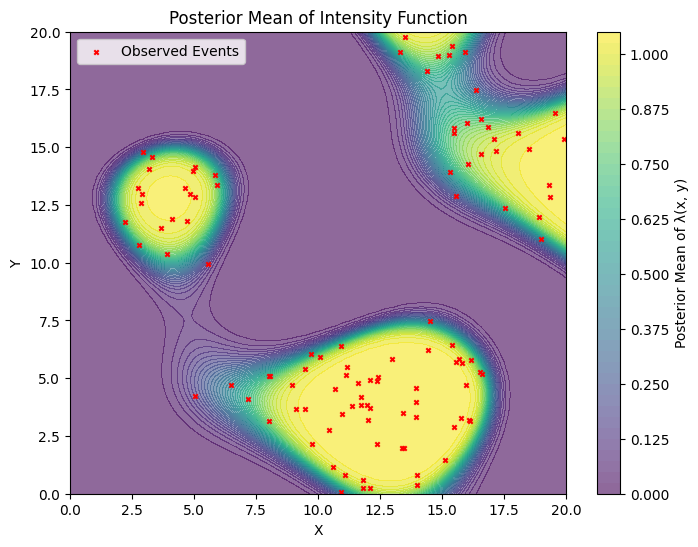

In [17]:
plot_intensity_posterior_2d(
    region=region,
    beta_samples=np.array(beta_samples),
    lambda_star_samples=np.array(lambda_star_samples),
    intensity_func=true_intensity_func.copy(),
    num_points=100,
    credible_interval=0.95,
    true_intensity_func=true_intensity_func.lambda_func,
    events=X_obs[y_obs == 1]
)


ほとんど強度関数は復元できているが、強度の最大値が過小評価されている気がする。